## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris,make_circles,make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import time

## Utilities

In [2]:
def plot_decision_boundary(clf, X, Y):
    classes = np.unique(Y)
    n_classes = len(classes)
    plot_step = 0.04

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel("X1")
    plt.ylabel("X2")

    # Define unique colors for each class
    unique_colors = plt.cm.RdYlBu(np.linspace(0, 1, n_classes))

    # Plot the training points with unique colors for each class
    for i, color in zip(range(n_classes), unique_colors):
        idx = np.where(Y == classes[i])
        plt.scatter(X[idx, 0], X[idx, 1], label=i, color=color, edgecolor='black', s=16)

    plt.legend(loc='lower right', borderpad=0, handletextpad=0)
    plt.axis("tight")

    return cs

## Datasets

In [3]:
iris = load_iris(return_X_y=True)
circles = make_circles(n_samples=100, noise=0.1, factor=0.2)
moons = make_moons(n_samples=100, noise=0.1)
scalers = [StandardScaler() for i in range(4)]
iris_scaled = (scalers[0].fit_transform(iris[0]), iris[1])
circles_scaled = (scalers[1].fit_transform(circles[0]), circles[1])
moons_scaled = (scalers[2].fit_transform(moons[0]), moons[1])

In [4]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt",sep=",",names=['variance','skewness','curtosis','entropy','class'])
X=df.drop('class',axis=1).to_numpy()
y=df['class'].to_numpy()
X,temp_a,y,temp_b = train_test_split(X,y,test_size=0.87,random_state=42)
banknote = X,y
banknote_scaled = (scalers[3].fit_transform(banknote[0]), banknote[1])

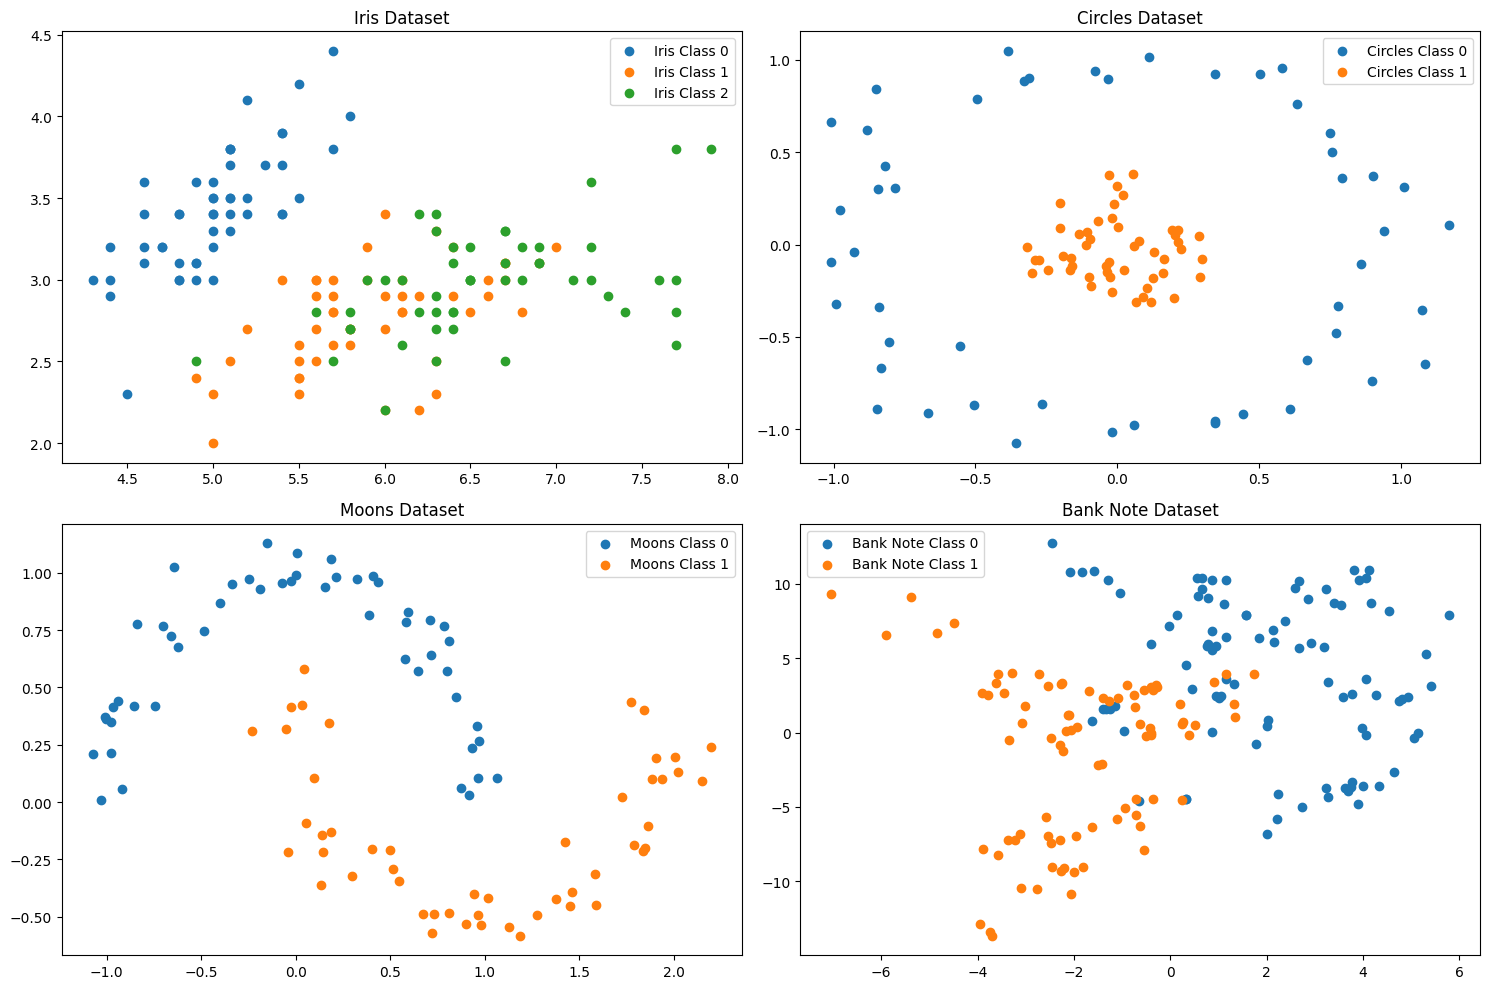

In [5]:
plt.figure(figsize=(15, 10))

# Plot Iris dataset
plt.subplot(2, 2, 1)
plt.scatter(iris[0][iris[1] == 0, 0], iris[0][iris[1] == 0, 1], label='Iris Class 0')
plt.scatter(iris[0][iris[1] == 1, 0], iris[0][iris[1] == 1, 1], label='Iris Class 1')
plt.scatter(iris[0][iris[1] == 2, 0], iris[0][iris[1] == 2, 1], label='Iris Class 2')   
plt.title('Iris Dataset')   
plt.legend()

# Plot Circles dataset
plt.subplot(2, 2, 2)
for i in np.unique(circles[1]):
    plt.scatter(circles[0][circles[1] == i, 0], circles[0][circles[1] == i, 1], label=f'Circles Class {i}')
plt.title('Circles Dataset')
plt.legend()

# Plot Moons dataset
plt.subplot(2 , 2, 3)
for i in np.unique(moons[1]):
    plt.scatter(moons[0][moons[1] == i, 0], moons[0][moons[1] == i, 1], label=f'Moons Class {i}')
plt.title('Moons Dataset')
plt.legend()

# Plot Bank Note dataset
plt.subplot(2, 2, 4)
plt.scatter(banknote[0][banknote[1] == 0, 0], banknote[0][banknote[1] == 0, 1], label='Bank Note Class 0')
plt.scatter(banknote[0][banknote[1] == 1, 0], banknote[0][banknote[1] == 1, 1], label='Bank Note Class 1')
plt.title('Bank Note Dataset')
plt.legend()

plt.tight_layout()
plt.show()

## Models

In [7]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000,kernel='linear',gamma='auto',a=0,b=1):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.kernel = kernel
        self.gamma = gamma
        self.weights = None
        self.bias = None
        self.a=a
        self.b=b
        self.n_features = None
        self.n_classes = None
        self.classes = None
        
    def get_gram(self,x1, x2, kernel):
        return np.array([[kernel(_x1, _x2) for _x2 in x2] for _x1 in x1])

    def RBF(self,x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1-x2))
    
    def POLY(self,x1,x2):
        return (self.a+np.dot(x1.T,x2))**self.b

    def fit(self, x, y):
        self.x_train = x
        self.y_train = y
        self.n_features = x.shape[1]
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.reverse_mapping = {c: i for i, c in enumerate(self.classes)}
        y = np.array([self.reverse_mapping[c] for c in y])
        if(self.kernel=='rbf'):
            if(self.gamma=='auto'):
                self.gamma = 1/(self.x_train.shape[1]*self.x_train.var())
            x = self.get_gram(x,x,self.RBF)
        elif(self.kernel=='poly'):
            x = self.get_gram(x,x,self.POLY)
        n_samples, n_features = x.shape
        self.classifiers = [None]*self.n_classes

        for c in range(self.n_classes):
            y_binary = np.where(y == c, 1, -1)
            weights = np.zeros(n_features)
            bias = 0

            for _ in range(self.n_iters):
                y_pred = np.dot(x, weights) + bias
                hinge_loss_grad = np.where(1 - y_binary * y_pred <= 0, 0, -y_binary)
                dw = (1 / n_samples) * np.dot(x.T, hinge_loss_grad) + (1 / n_samples) * self.lambda_param * weights
                db = (1 / n_samples) * np.sum(hinge_loss_grad)

                weights -= self.learning_rate * dw
                bias -= self.learning_rate * db

            self.classifiers[int(c)] = (weights, bias)

    def predict(self, x):
        if(self.kernel=='rbf'):
            x = self.get_gram(x,self.x_train,self.RBF)
        elif(self.kernel=='poly'):
            x = self.get_gram(x,self.x_train,self.POLY)
        scores = {c: np.dot(x, self.classifiers[int(c)][0]) + self.classifiers[int(c)][1] for c in range(self.n_classes)}
       
        predictions = []
        for i in range(x.shape[0]):
            max_class = None
            max_score = float('-inf')
            for c in range(self.n_classes):
                if scores[c][i] > max_score:
                    max_score = scores[c][i]
                    max_class = c
            predictions.append(self.classes[max_class])
        return np.array(predictions)


## Tests

In [8]:
models = [SVM(kernel='linear'),SVM(kernel='rbf'),SVM(kernel='poly',a=1,b=2),SVC(kernel='linear'),SVC(kernel='rbf'),SVC(kernel='poly')]
datasets = [iris_scaled, circles_scaled, moons_scaled, banknote_scaled]
dataset_names = ['Iris', 'Circles', 'Moons', 'Bank Note']
model_names = ['SVM', 'SVC']
kernel_names = ['Linear','Rbf','Poly']
b = {'Moons': 3,'Circles':2,'Iris':2,'Bank Note':1}

In [9]:
index = pd.MultiIndex.from_product([dataset_names, kernel_names], names=['Dataset', 'Kernel'])
df = pd.DataFrame(index=index, columns=model_names + ['Time'])

In [10]:
def get_plots_and_accuracies(dataset, dataset_name,models,b,df):
    fig = plt.figure(figsize=(15, 7.5))
    X, Y = dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    for j, model in enumerate(models):
        if dataset_name == 'Iris' or dataset_name== 'Bank Note':
            X_train = PCA(n_components=2).fit_transform(X_train)
            X_test = PCA(n_components=2).fit_transform(X_test)
        if model.kernel=='poly' and model.__class__.__name__=='SVM':
            model.b = b[dataset_name]
        model.fit(X_train, Y_train)
        
        plt.subplot(2, 3, j+1)
        plot_decision_boundary(model, X_train, Y_train)
        plt.title(f'{model.__class__.__name__} - {model.kernel} on {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

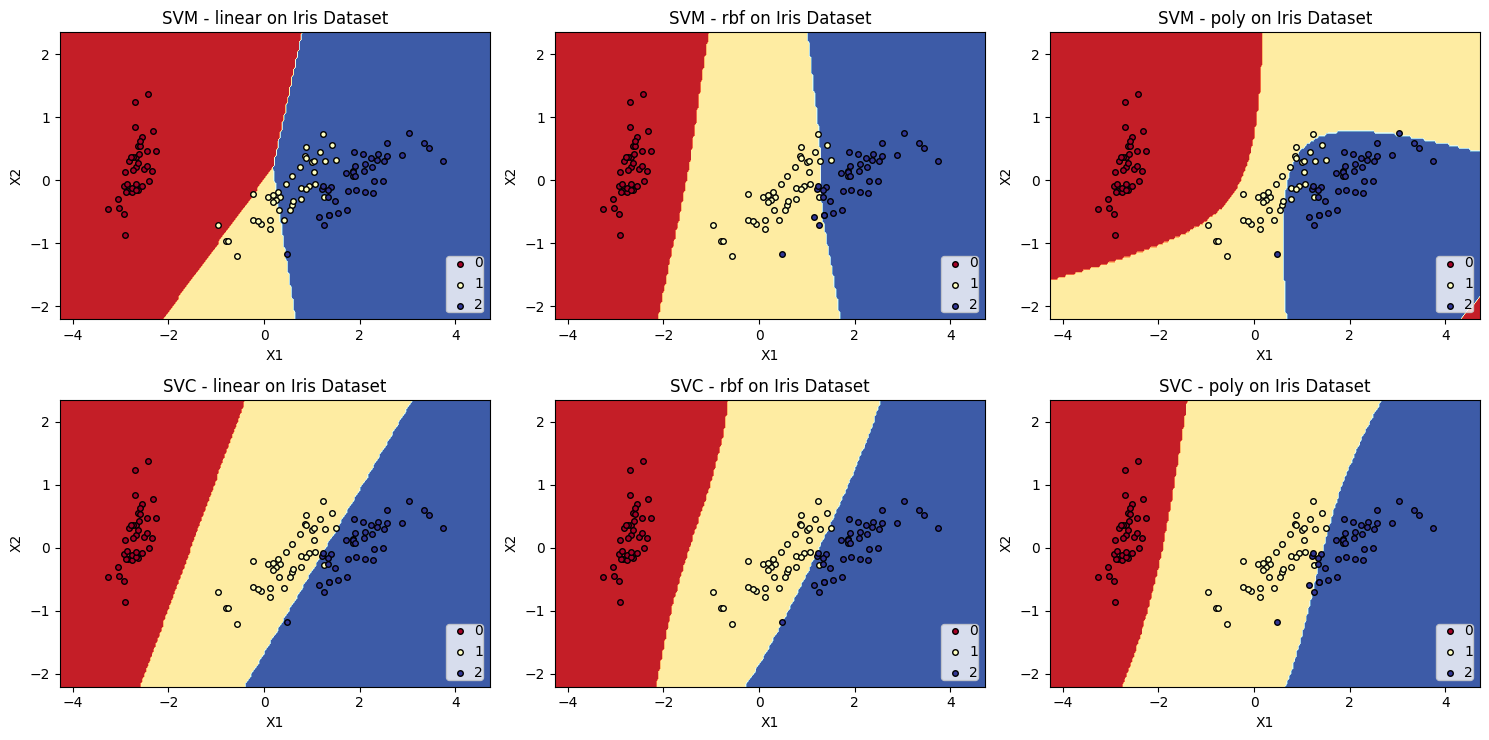

In [20]:
get_plots_and_accuracies(iris, 'Iris',models,b,df)

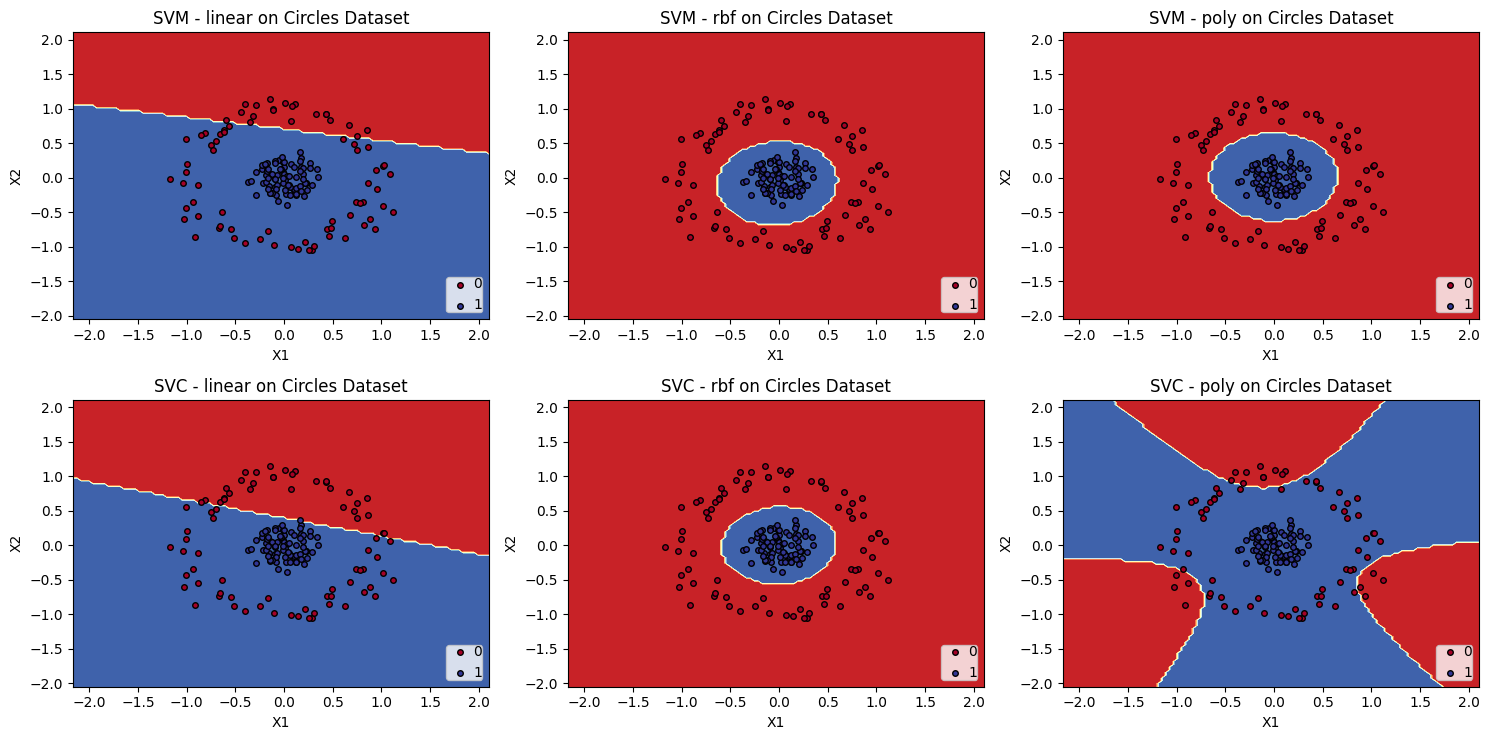

In [12]:
get_plots_and_accuracies(circles, 'Circles',models,b,df)

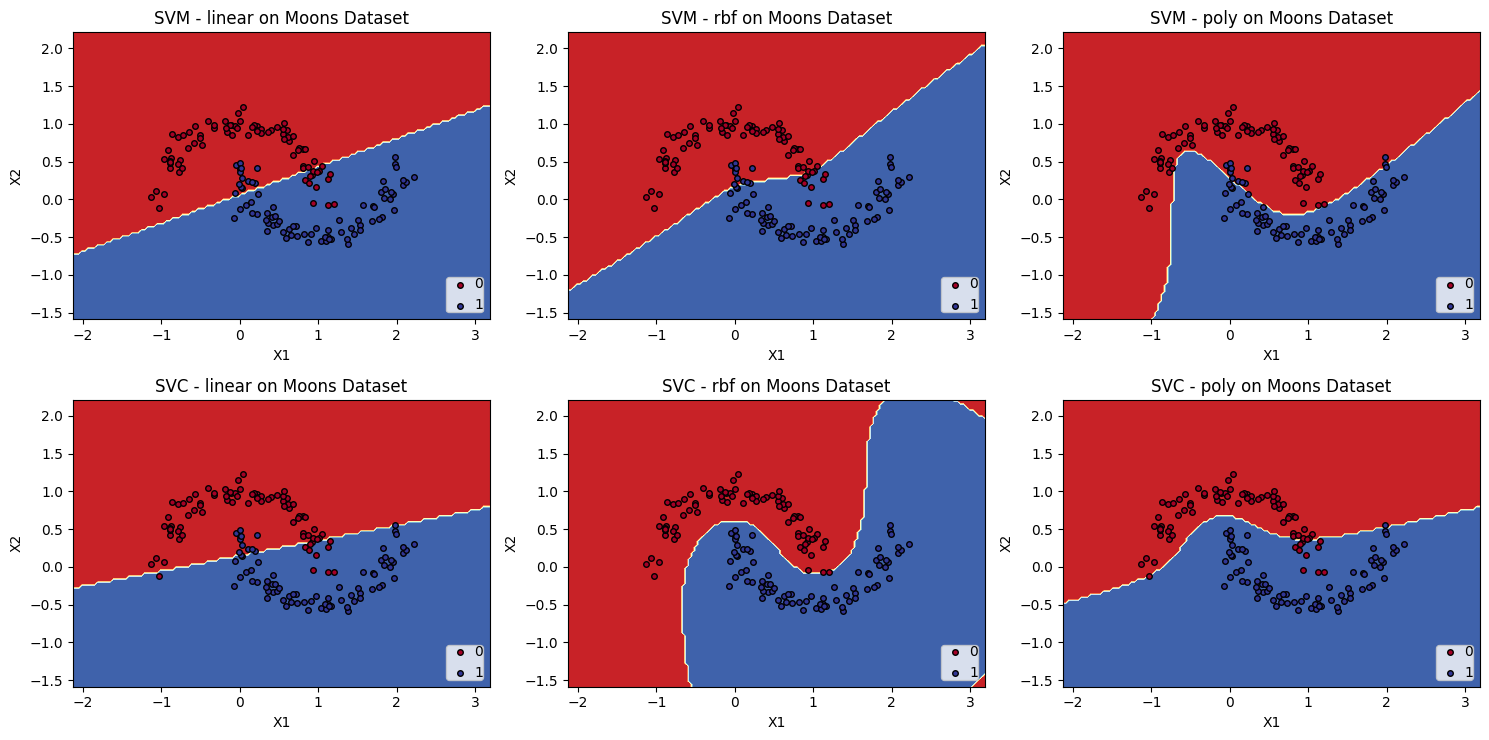

In [13]:
get_plots_and_accuracies(moons, 'Moons',models,b,df)

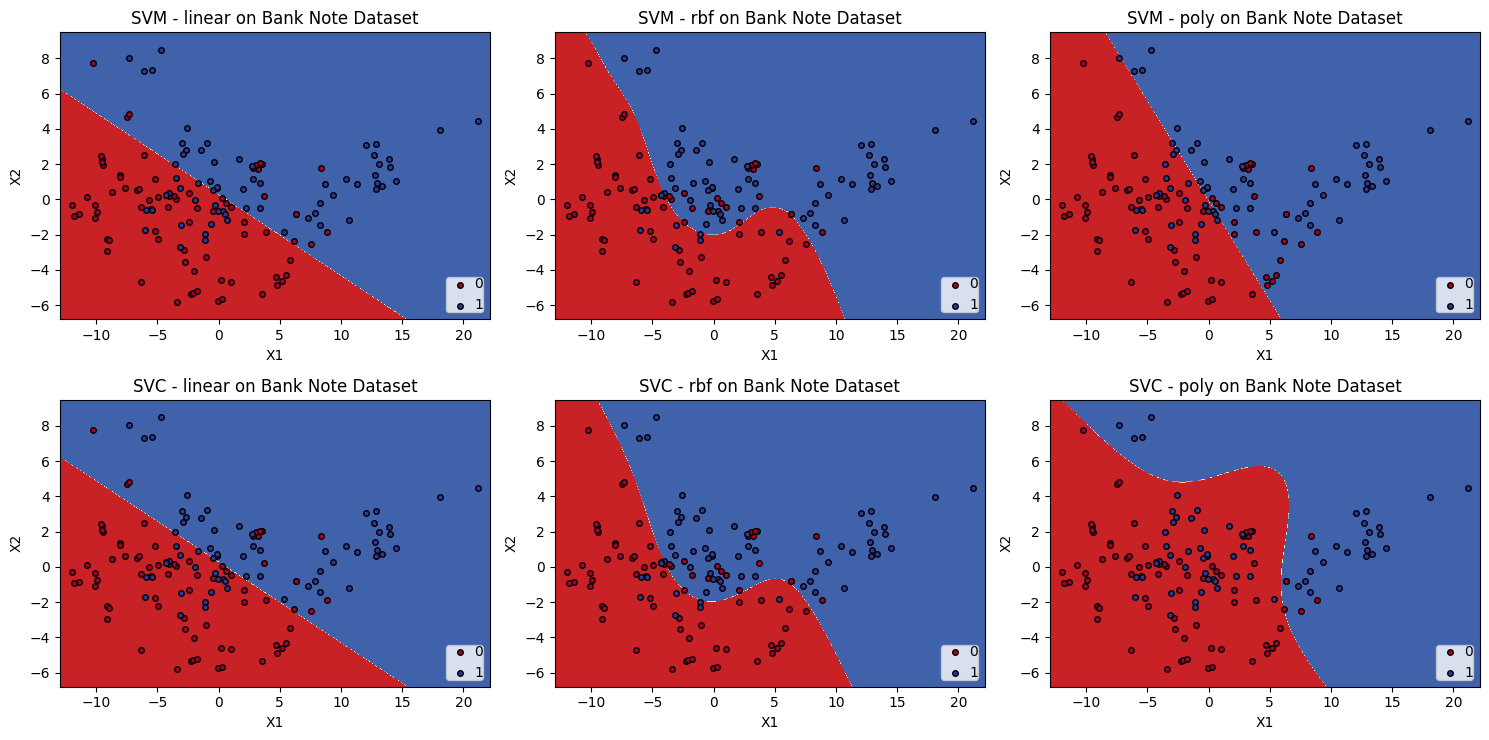

In [14]:
get_plots_and_accuracies(banknote, 'Bank Note',models,b,df)

In [22]:
class Converter():
    def __init__(self):
        self.f=None
        self.svm=None
    
    def write_list(self,f,name,lst,is_str=False,max_len=50):
        if(is_str):
            f.write(f"char {name}[{len(lst)}][{max_len}] = ")
        else:
            f.write(f"double {name}[{len(lst)}] = ")
        f.write("{\n")
        if(is_str):
            for i,x in enumerate(lst):
                if(i==len(lst)-1):
                    f.write(f'\t"{x}"\n')
                else:
                    f.write(f'\t"{x}",\n')
        else:
            for i,x in enumerate(lst):
                if(i==len(lst)-1):
                    f.write(f"\t{x}\n")
                else:
                    f.write(f"\t{x},\n")
        f.write("};\n\n")
    
    def write_classifiers(self,f,lst):
        f.write(f"double weights[{len(lst)}][{len(lst[0][0])}] = "+"{\n")
        for i in range(len(lst)):
            f.write("\t{")
            for j in range(len(lst[i][0])):
                if(j==len(lst[i][0])-1):
                    f.write(f"{lst[i][0][j].round(self.precision)}")
                else:
                    f.write(f"{lst[i][0][j].round(self.precision)},")
            if(i==len(lst)-1):
                f.write("}\n")
            else:
                f.write("},\n")
        f.write("};\n\n")
        
        self.write_list(f,'bias',[round(x[1],self.precision) for x in lst])
        
    def write_matrix(self,f,name,lst):
        f.write(f'double {name}[{lst.shape[0]}][{lst.shape[1]}] = '+'{\n')
        for j,x in enumerate(lst):
            f.write('\t{')
            for i,y in enumerate(x):
                if(i==len(x)-1):
                    f.write(f'{y} ')
                else:
                    f.write(f'{y}, ')
            if(j==len(lst)-1):
                f.write('}\n')
            else:
                f.write('},\n')
        f.write('};\n\n')
    
    def convert(self,file_name,svm,X_test,y_test,dataset,std_enc=None,precision=12):
        num_classes = svm.n_classes
        num_features = svm.n_features
        classes = svm.classes
        X_train = svm.x_train
        self.svm=svm
        self.precision = precision
        num_training_samples = len(X_train)
        __X_train = X_train
        if(svm.kernel =='linear'):
            __X_train = np.zeros((1,num_features))
            num_training_samples = 1
        
        mean = [0.0]*num_features if std_enc is None else std_enc.mean_
        std_dev = [1.0]*num_features if std_enc is None else std_enc.scale_

        mean = [float(x) for x in mean]
        std_dev = [float(x) for x in std_dev]

        __X_train = __X_train.astype(float).round(precision)
        X_test = X_test.astype(float).round(precision)


        upper_f = file_name.upper()
        upper_f=upper_f.replace('.','_')
        with open(file_name, 'w') as f:
            self.f=f
            f.write(f"#ifndef {upper_f}\n")
            f.write(f"#define {upper_f}\n\n")
            f.write("#define NUM_CLASSES {}\n".format(num_classes))
            f.write("#define NUM_FEATURES {}\n\n".format(num_features))
            f.write("#define WEIGHT_LEN {}\n".format(len(svm.classifiers[0][0])))
            f.write("#define NUM_SAMPLES {}\n".format(len(X_test)))
            f.write("#define NUM_TRAINING_SAMPLES {}\n\n".format(num_training_samples))
            f.write("#define GAMMA {}\n".format(0.0 if type(svm.gamma) == str else svm.gamma))
            
            f.write("#define A {}\n".format(svm.a))
            f.write("#define B {}\n\n".format(svm.b))
            
            f.write(f'char kernel[50] = "{svm.kernel}";\n')
            f.write(f'char dataset[50] = "{dataset}";\n')
            self.write_list(f,'mean',mean)
            self.write_list(f,'std_dev',std_dev)
            self.write_classifiers(f,svm.classifiers)
            self.write_list(f,'classes',classes,is_str=True)
            self.write_matrix(f,'X_test',X_test)
            self.write_list(f,'y_test',y_test,is_str=True)
            self.write_matrix(f,'X_train',__X_train)
            f.write("#endif // SVM_CLASSIFIER_H\n")
                
    

In [31]:
index = pd.MultiIndex.from_product([dataset_names, kernel_names], names=['Dataset', 'Kernel'])
df = pd.DataFrame(index=index, columns=model_names + ['Time'])

In [32]:
datasets_unscaled = [iris,circles, moons, banknote]

for model in models[:3]:
    for dataset,data_name in zip(datasets_unscaled,['Iris','Circles','Moons','Bank Note']):
        X, Y = dataset
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        temp = X_test
        X_test = scaler.transform(X_test)
        model.fit(X_train, Y_train)
        start_time = time.time()
        Y_pred = model.predict(X_test)
        end_time = time.time()
        accuracy = accuracy_score(Y_test, Y_pred)
        accuracy = round(accuracy * 100, 2)
        df.loc[(data_name, model.kernel.capitalize()), model.__class__.__name__] = accuracy
        df.loc[(data_name, model.kernel.capitalize()), 'Time'] = (end_time - start_time)
        converter = Converter()
        converter.convert(f'{model.__class__.__name__}_{model.kernel}_{data_name.replace(' ','_')}.h',model,temp,Y_test,dataset=data_name,std_enc=scaler,precision=16)

In [33]:
datasets_unscaled = [iris,circles, moons, banknote]

for model in models[3:]:
    for dataset,data_name in zip(datasets_unscaled,['Iris','Circles','Moons','Bank Note']):
        X, Y = dataset
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, Y_train)
        start_time = time.time()
        Y_pred = model.predict(X_test)
        end_time = time.time()
        accuracy = accuracy_score(Y_test, Y_pred)
        accuracy = round(accuracy * 100, 2)
        df.loc[(data_name, model.kernel.capitalize()), model.__class__.__name__] = accuracy
        df.loc[(data_name, model.kernel.capitalize()), 'Time'] = (end_time - start_time)

In [35]:
df_style = df.style.format({'SVM':"{:.2f}",'SVC':"{:.2f}"}).set_table_styles([
    {'selector': 'th',
     'props': [('text-align', 'center'), ('font-size', '14px')]},
    {'selector': 'td',
     'props': [('text-align', 'center'), ('font-size', '14px')]},
])
df_style